# The Woof Factor in Zürich
Some general description of the project would be nice here.

*Team #23:* Jacob Gelling, ...






# Libraries
Required packages are installed and libraries imported.

In [2]:
install.packages("readr")
install.packages("data.table")
install.packages("RYandexTranslate")
install.packages("plyr")
install.packages("dplyr")
install.packages("stringr")
install.packages("class")
install.packages("e1071")
install.packages("ggplot2")
install.packages("reshape2")
install.packages("leaflet")
install.packages("rgdal")

library(readr)
library(data.table)
library(RYandexTranslate)
library(plyr)
library(dplyr)
library(stringr)
library(class)
library(e1071)
library(ggplot2)
library(reshape2)
library(leaflet)
library(rgdal)

Installing package into ‘/home/jacob/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jacob/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jacob/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)

also installing the dependencies ‘curl’, ‘httr’


Installing package into ‘/home/jacob/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jacob/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jacob/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jacob/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jacob/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jacob/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jacob/R/x86_64-pc-linux-gnu-

# Data Cleaning
This section is used for importing the raw data from CSV files into data tables.

Appropriate data merging and cleaning is performed, along with translations from German to English.

Rather than re-run data cleaning, which can be slow due to the Yandex translation API, an R data image of the alreadly cleaned data can be loaded instead.

In [49]:
load("dogs.Rdata")

## Import Dog Data

Data source available at [Stadt Zürich Open Data](https://data.stadt-zuerich.ch/dataset/sid_stapo_hundebestand/resource/a05e2101-7997-4bb5-bed8-c5a61cfffdcf).

In [29]:
dogs2020 <- data.table(read_csv("data_sources/20200306_hundehalter.csv"))

# Data Artifact - Dog w. District "8" Typographical Error? We Remove. Good example of Data Cleaning. 
dogs2020 <- dogs2020[(dogs2020$STADTQUARTIER!=8), ]

#removing unnececesary columns
dogs2020[, c("RASSE1_MISCHLING", "RASSE2", "RASSE2_MISCHLING"):=NULL]

#if a row has a NA entry in one of the cells, remove the entire row
dogs2020 <- na.omit(dogs2020)
# 0 rows ommited, still leave the code in place in case we change data basis.

#rename columns
setnames(dogs2020, old = c("HALTER_ID", "ALTER", "GESCHLECHT", "STADTQUARTIER", "STADTKREIS", "RASSE1", "RASSENTYP", "GEBURTSJAHR_HUND", "GESCHLECHT_HUND", "HUNDEFARBE")
                  , new = c("OWNER_ID", "AGE", "SEX", "DISTRICT", "DISTRICT_BIG", "BREED", "BREED_TYPE", "YOB_DOG", "SEX_DOG", "COLOR_DOG"))


# couse stadtquartier is more granular district segmentation than stadtkreis, and not all datasets
# can be merged by stadtkreis we used it. however it is hard to match on a map
# dogs dataset does not contain normal district names. so we use wealth dataset to extract them
# from zurich city databases

district_names <- data.table(read_csv("data_sources/wir100od1004.csv"))
district_names <- unique(district_names[, QuarSort, QuarLang])

#renaming
setnames(district_names, old = c("QuarSort", "QuarLang")
         , new = c("DISTRICT", "DISTRICT_NAME"))

dogs2020 <- merge(dogs2020, district_names , by = "DISTRICT", all.x = T)

#remove unused variables
rm(district_names)

Parsed with column specification:
cols(
  HALTER_ID = col_double(),
  ALTER = col_character(),
  GESCHLECHT = col_character(),
  STADTKREIS = col_double(),
  STADTQUARTIER = col_double(),
  RASSE1 = col_character(),
  RASSE1_MISCHLING = col_character(),
  RASSE2 = col_character(),
  RASSE2_MISCHLING = col_logical(),
  RASSENTYP = col_character(),
  GEBURTSJAHR_HUND = col_double(),
  GESCHLECHT_HUND = col_character(),
  HUNDEFARBE = col_character()
)

Parsed with column specification:
cols(
  SteuerJahr = col_double(),
  QuarSort = col_double(),
  QuarLang = col_character(),
  SteuerTarifSort = col_double(),
  SteuerTarifLang = col_character(),
  SteuerVermoegen_p50 = col_double(),
  SteuerVermoegen_p25 = col_double(),
  SteuerVermoegen_p75 = col_double()
)



## Import Wealth Data

Data source available at [Stadt Zürich Open Data](https://data.stadt-zuerich.ch/dataset/fd_median_einkommen_quartier_od1003).

In [30]:
wealth <- data.table(read_csv("data_sources/wir100od1004.csv"))

# we dont have data for 2020, the freshest data is on 2017
wealth <- wealth[SteuerJahr == 2017,]
# creating new column where to store average
wealth[, wealth50 := SteuerVermoegen_p50]
# replacing family values in this column with same devided by 2 for normalization
wealth$wealth50[wealth$SteuerTarifSort == 1] <- wealth$wealth50[wealth$SteuerTarifSort == 1]/2

#aggregating data for family status
#new table      old table, select mean of incomep50 (ignore NA), aggregate it by Quartal
wealth_merge <- wealth[,mean(wealth50, na.rm = T), by=QuarSort]

#leaving only quartals that have dogs in them
wealth_merge <- wealth_merge[wealth_merge$QuarSort %in% dogs2020$DISTRICT]

#renaming
setnames(wealth_merge, old = c("V1", "QuarSort")
         , new = c("WEALTH_T_CHF", "DISTRICT"))

#merge income into dogs dataset
dogs2020 <- merge(dogs2020, wealth_merge, by = "DISTRICT", all.x = T)
# ATTENTION! FYI: not for all districts we have wealth values! 

#get rid of unused data
rm(wealth, wealth_merge)

Parsed with column specification:
cols(
  SteuerJahr = col_double(),
  QuarSort = col_double(),
  QuarLang = col_character(),
  SteuerTarifSort = col_double(),
  SteuerTarifLang = col_character(),
  SteuerVermoegen_p50 = col_double(),
  SteuerVermoegen_p25 = col_double(),
  SteuerVermoegen_p75 = col_double()
)



## Import Income Data

Data source available at [Stadt Zürich Open Data](https://data.stadt-zuerich.ch/dataset/fd_median_vermoegen_quartier_od1004).

In [31]:
income <- data.table(read_csv("data_sources/wir100od1003.csv"))

# we dont have data for 2020, the freshest data is on 2017
income <- income[SteuerJahr == 2017,]
#creating new column where to store average
income[, incomep50 := SteuerEInkommen_p50]
# replacing family values in this column with same devided by 2 for normalization
income$incomep50[income$SteuerTarifSort == 1] <- income$incomep50[income$SteuerTarifSort == 1]/2

#aggregating data for family status
#new table      old table, select mean of incomep50 (ignore NA), aggregate it by Quartal
income_merge <- income[,mean(incomep50, na.rm = T), by=QuarSort]

#leaving only quartals that have dogs in them
income_merge <- income_merge[income_merge$QuarSort %in% dogs2020$DISTRICT]

#renaming
setnames(income_merge, old = c("V1", "QuarSort")
         , new = c("INCOME_T_CHF", "DISTRICT"))

#merge income into dogs dataset
dogs2020 <- merge(dogs2020, income_merge, by = "DISTRICT", all.x = T)
# ATTENTION! FYI: not for all districts we have income values! 

#get rid of unused data
rm(income, income_merge)

Parsed with column specification:
cols(
  SteuerJahr = col_double(),
  QuarSort = col_double(),
  QuarLang = col_character(),
  SteuerTarifSort = col_double(),
  SteuerTarifLang = col_character(),
  SteuerEInkommen_p50 = col_double(),
  SteuerEinkommen_p25 = col_double(),
  SteuerEinkommen_p75 = col_double()
)



## Import Education Data

Data source available at [Stadt Zürich Open Data](https://data.stadt-zuerich.ch/dataset/bfs_bev_bildungsstand_statquartier_seit1970_od1012).

In [32]:
education <- data.table(read_csv("data_sources/bil101od1012 (2).csv"))

### long to wide education reshape
education <-dcast(education, RaumSort ~ Bildungsstand, value.var = "AntBev")

#renaming for merge
setnames(education, old = c("RaumSort", "Obligatorische Schule", "Sekundarstufe II", "Tertiärstufe"), 
                    new = c("DISTRICT", "BASIC_SCHOOL_PERCENTAGE", "GYMNASIUM_PERCENTAGE", "UNIVERSITY_PERCENTAGE"))

# merge into main data.table
dogs2020 <- merge(dogs2020, education, by = "DISTRICT", all.x = T)

# remove not needed variables
rm(education)

Parsed with column specification:
cols(
  RaumSort = col_double(),
  RaumLang = col_character(),
  Bildungsstand = col_character(),
  AntBev = col_double(),
  untAntBevKI = col_double(),
  obAntBevKI = col_double()
)



## Import Home Type Data

Data source available at [Stadt Zürich Open Data](https://data.stadt-zuerich.ch/dataset/bau_best_geb_whg_bev_gebaeudeart_quartier_seit2008/resource/3850add1-264c-4993-98cd-d8a9ba87ee25).

In [33]:
home_type <- data.table(read_csv("data_sources/bau_best_geb_whg_bev_gebaeudeart_quartier_seit2008.csv")) 

# we dont have date for 2020, the freshest data is on 2019
home_type <- home_type[Jahr == 2019,]

# Counting sum number of every type of building (less granular)
home_type <- home_type[, sum(AnzGeb), by = list(QuarSort,GbdArtPubName)]

#renaming for merge
setnames(home_type, old = c("QuarSort", "GbdArtPubName", "V1"), 
         new = c("DISTRICT", "Hometype", "Number_homes"))

### long to wide hometype reshape
home_type <- data.table::dcast(home_type, DISTRICT ~ Hometype, value.var = "Number_homes")

# translate hometype
setnames(home_type, old = c("Produktions- und Lagergebäude", "Mehrfamilienhäuser", "Einfamilienhäuser", "Infrastrukturgebäude", "Kleingebäude", "Kommerzielle Gebäude", "Spezielle Wohngebäude"), 
         new = c("FACTORIES_AND_WAREHOUSES", "APARTMENTS", "SINGLE_FAMILY_HOMES", "INFRASTRUCTURE_BUILDINGS", "SMALL_BUILDINGS", "COMMERCIAL_BUILDINGS", "SPECIAL_ACCOMODATION"))

#removing unnececesary column
home_type[, Unbekannt:=NULL]

#merging
dogs2020 <- merge(dogs2020, home_type, by = "DISTRICT", all.x = T)

# removing not needed variables
rm(home_type)

Parsed with column specification:
cols(
  Jahr = col_double(),
  QuarSort = col_double(),
  QuarLang = col_character(),
  GbdArt1 = col_double(),
  GbdArt1n = col_character(),
  AnzGeb = col_double(),
  Rauminhalt = col_double(),
  PersonenGT2 = col_character(),
  AnzWhg = col_double(),
  WohnFl = col_double(),
  PersInWhgGT2 = col_character(),
  KreisSort = col_double(),
  KreisLang = col_character(),
  GbdArt2 = col_double(),
  GbdArt2n = col_character(),
  GbdArtPub = col_double(),
  GbdArtPubName = col_character()
)



## Import Population Data

Data source available at [Stadt Zürich Open Data](https://www.stadt-zuerich.ch/prd/de/index/statistik/themen/bevoelkerung/bevoelkerungsentwicklung/kreise-und-quartiere.html#daten).

In [63]:
# Warning shown due to formatting of souce CSV header, can be ignored
pop_per_district <- data.table(read_csv("data_sources/2019-Table_1.csv"), col_names = TRUE, skip = 8)
pop_per_district

# Set Column Names
setnames(pop_per_district, old = "X1", new = "DISTRICT_NAME")


# This Reg-Ex Matching Function Removes all Whitespaces and not only conventional ones (bad data design)
pop_per_district[,2:5] <- data.table(apply(pop_per_district[,2:5], 2, function(x) gsub('[^0-9.]', '', x)))

# Join By District Name (Perfect Match, No N/A's)
dogs2020 <- merge(dogs2020, pop_per_district, by = "DISTRICT_NAME", all.x = T)

# removing not needed variables
rm(pop_per_district)

# Renaming
setnames(dogs2020,
         old = c("Total", "Schweizer/-innen", "Ausländer/-innen", "Anteil ausländische\nBevölkerung (%)"),
         new = c("TOTAL_POPULATION", "SWISS_POPULATION", "FOREIGN_POPULATION", "FOREIGN_POPULATION_PERCENTAGE")
)

# Then we cast as a numeric to prepare for mathematical operations that come later
dogs2020$TOTAL_POPULATION <- as.numeric(dogs2020$TOTAL_POPULATION)
dogs2020$SWISS_POPULATION   <- as.numeric(dogs2020$SWISS_POPULATION)
dogs2020$FOREIGN_POPULATION   <- as.numeric(dogs2020$FOREIGN_POPULATION  )
dogs2020$FOREIGN_POPULATION_PERCENTAGE   <- as.numeric(dogs2020$FOREIGN_POPULATION_PERCENTAGE)

Warning message:
“Missing column names filled in: 'X2' [2], 'X3' [3], 'X4' [4], 'X5' [5]”
Parsed with column specification:
cols(
  T_1 = col_character(),
  X2 = col_character(),
  X3 = col_character(),
  X4 = col_character(),
  X5 = col_character()
)



T_1,X2,X3,X4,X5,col_names,skip
<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>
Ausländeranteil und Bevölkerung,NA,NA,NA,NA,TRUE,8
"nach Herkunft, Stadtkreis und Stadtquartier",NA,NA,NA,NA,TRUE,8
2019,NA,NA,NA,NA,TRUE,8
,NA,NA,NA,NA,TRUE,8
"Quelle: Statistik Stadt Zürich, BVS6",NA,NA,NA,NA,TRUE,8
,NA,NA,NA,NA,TRUE,8
NA,NA,NA,NA,NA,TRUE,8
NA,Total,Schweizer/-innen,Ausländer/-innen,Anteil ausländische Bevölkerung (%),TRUE,8
Ganze Stadt,434 008,294 205,139 803,32.2,TRUE,8


ERROR: Error in setnames(pop_per_district, old = "X1", new = "DISTRICT_NAME"): Items of 'old' not found in column names: [X1]. Consider skip_absent=TRUE.


## Translate Dataframes
Using the Yandex Translate API, values in columns are automatically translated from German to English.

Firstly the Yandex translate package is fixed, as per the [solution found on GitHub](https://github.com/mukul13/RYandexTranslate/issues/2).

In [40]:
translate = function (api_key, text = "", lang = "") 
{
  url = "https://translate.yandex.net/api/v1.5/tr.json/translate?"
  url = paste(url, "key=", api_key, sep = "")
  if (text != "") {
    url = paste(url, "&text=", text, sep = "")
  }
  if (lang != "") {
    url = paste(url, "&lang=", lang, sep = "")
  }
  url = gsub(pattern = " ", replacement = "%20", x = url)
  d = RCurl::getURL(url, ssl.verifyhost = 0L, ssl.verifypeer = 0L, .encoding = "UTF-8")
  d = jsonlite::fromJSON(d)
  d$code = NULL
  d
}

We then loop through columns that we wish to translate and pass these to the translator.

In [41]:
# yandex translater need api, this is API connected to my personal account. (Andris)
# please dont use it elsewhere
api_key <- "trnsl.1.1.20200515T134653Z.f9fb709ac3e94036.783aefa609692b463a79b5827d5c0e7f2d037a8c"

# List of columns in which we nat to translate contents
column_list <- c("BREED", "COLOR_DOG")

# looping through columns
for (column_names in column_list) {
  # get all unique values in the coresponding columns,
  # cause values repeat, it speeds up translation with mass replacing one translation
  # and not repeating translation for every word, even if it was translated before.
  unique_values <- unique(dogs2020[,get(column_names)])
  
  # looping through unique values to be translated
  for (unique_num in 1:length(unique_values)) {
    
    #debug
    print(column_names)
    print(paste(unique_num, " out of ", length(unique_values)))
    
    # translating code: This is a data.table synthaxis code.
    # what table we use
    dogs2020[
      # select all rows where value is equal to current unique value
      # left part "get" is needed in order to use dynamic column_names
      dogs2020[,get(column_names)] == unique_values[unique_num],
      # replace old value with translated one
      # left part is "eval" is needed in order to use dynamic column_names
      # right part is a yandex translater function, providing api_key and text to be translated
      eval(column_names) := translate(api_key,text=unique_values[unique_num],
      # specify language pare and translation direction                                
      lang="de-en"
      # extract only output text from the return given by yandex
      )$text]
  
  }
}

# manually replace sex and sex_dog variable to match language conventions for sex abbriviations
dogs2020[SEX == "w",SEX := "f"]
dogs2020[SEX_DOG == "w",SEX_DOG := "f"]

[1] "BREED"
[1] "1  out of  314"
[1] "BREED"
[1] "2  out of  314"
[1] "BREED"
[1] "3  out of  314"
[1] "BREED"
[1] "4  out of  314"
[1] "BREED"
[1] "5  out of  314"
[1] "BREED"
[1] "6  out of  314"
[1] "BREED"
[1] "7  out of  314"
[1] "BREED"
[1] "8  out of  314"
[1] "BREED"
[1] "9  out of  314"
[1] "BREED"
[1] "10  out of  314"
[1] "BREED"
[1] "11  out of  314"
[1] "BREED"
[1] "12  out of  314"
[1] "BREED"
[1] "13  out of  314"
[1] "BREED"
[1] "14  out of  314"
[1] "BREED"
[1] "15  out of  314"
[1] "BREED"
[1] "16  out of  314"
[1] "BREED"
[1] "17  out of  314"
[1] "BREED"
[1] "18  out of  314"
[1] "BREED"
[1] "19  out of  314"
[1] "BREED"
[1] "20  out of  314"
[1] "BREED"
[1] "21  out of  314"
[1] "BREED"
[1] "22  out of  314"
[1] "BREED"
[1] "23  out of  314"
[1] "BREED"
[1] "24  out of  314"
[1] "BREED"
[1] "25  out of  314"
[1] "BREED"
[1] "26  out of  314"
[1] "BREED"
[1] "27  out of  314"
[1] "BREED"
[1] "28  out of  314"
[1] "BREED"
[1] "29  out of  314"
[1] "BREED"
[1] "30  ou

ERROR: Error in function (type, msg, asError = TRUE) : 


## Save RData Image

In [ ]:
save.image("dogs.Rdata")

## Backup Output
(Delete later once investigation does not directly edit dogs2020)

In [50]:
dogs2020_backup = copy(dogs2020)

# Investigation
This section of code explores predicting dog breed type.

## Model Preparation

In [51]:
# color recode to make bigger chunks
# doublecolored dogs will be recoded as singlecolored with first color taken as main.
a <- str_split(dogs2020$COLOR_DOG, "/")
new_colors <- a[[1]][1]
# clear variable i from the enviroment
rm(i)
for (i in 2:length(a)) {
  new_colors <- append(new_colors, a[[i]][1])
}
dogs2020$COLOR_DOG <- new_colors

# refactoring text attributes to numeric, so that knn can work with it.
dogs2020$DISTRICT_NAME <- as.numeric(as.factor(dogs2020$DISTRICT_NAME))
dogs2020$AGE <- as.numeric(as.factor(dogs2020$AGE))
dogs2020$SEX <- as.numeric(as.factor(dogs2020$SEX))
dogs2020$SEX_DOG <- as.numeric(as.factor(dogs2020$SEX_DOG))
dogs2020$COLOR_DOG <- as.numeric(as.factor(dogs2020$COLOR_DOG))
dogs2020$YOB_DOG <- as.numeric(as.factor(dogs2020$YOB_DOG))

#saving labels in order to see later what numbers represent what breedtypes
breedtype_labels <- as.factor(dogs2020$BREED_TYPE)
dogs2020$BREED_TYPE <- as.numeric(as.factor(dogs2020$BREED_TYPE))

#saving labels in order to see later what numbers represent what breeds
breed_labels <- as.factor(dogs2020$BREED)
dogs2020$BREED <- as.numeric(as.factor(dogs2020$BREED))

## Naive Approach

In [52]:
# data separation, so that we have test and training group
dat.d <- sample(1:nrow(dogs2020),size=nrow(dogs2020)*0.7,replace = FALSE) #random selection of 70% data.

# now we tried differrent input settings in an attempt to find optimal one

# train.dogs <- dogs2020[dat.d, c("DISTRICT_NAME", "YOB_DOG", "AGE", "SEX", "SEX_DOG", "COLOR_DOG")] # 70% training data
# test.dogs <- dogs2020[-dat.d,c("DISTRICT_NAME", "YOB_DOG", "AGE", "SEX", "SEX_DOG", "COLOR_DOG")] # remaining 30% test data

# train.dogs <- dogs2020[dat.d, c("DISTRICT_NAME", "YOB_DOG", "AGE", "SEX", "SEX_DOG")] # 70% training data
# test.dogs <- dogs2020[-dat.d,c("DISTRICT_NAME", "YOB_DOG", "AGE", "SEX", "SEX_DOG")] # remaining 30% test data

# train.dogs <- dogs2020[dat.d, c("COLOR_DOG")] # 70% training data
# test.dogs <- dogs2020[-dat.d,c("COLOR_DOG")] # remaining 30% test data

# this is the only setting where we are not "cheating" by using dog associated attributes
train.dogs <- dogs2020[dat.d, c("DISTRICT_NAME", "AGE", "SEX")] # 70% training data
test.dogs <- dogs2020[-dat.d,c("DISTRICT_NAME", "AGE", "SEX")] # remaining 30% test data

train.dogs_labels <- dogs2020[dat.d,BREED]
test.dogs_labels <-dogs2020[-dat.d,BREED]

# train.dogs_labels <- dogs2020[dat.d,group]
# test.dogs_labels <-dogs2020[-dat.d,group]


#aprox k value
k_value <-  sqrt(nrow(dogs2020))

knn.test <- knn(train=train.dogs, test=test.dogs, cl=train.dogs_labels, k=k_value)

ACC.test <- 100 * sum(test.dogs_labels == knn.test)/NROW(test.dogs_labels)

table(knn.test ,test.dogs_labels)

ACC.test

# accuracy of direct prediction is 9,22%

        test.dogs_labels
knn.test  2  3  4  6 10 11 13 14 15 16 17 18 20 22 25 26 27 28 30 32 35 36 37
     1    0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     2    0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     3    0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     4    0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     5    0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     7    0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     8    0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     9    0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     10   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     11   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     12   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
     13   0  0  0  0  0  0  0  0  0  0 

[1] 9.991497

## Lets try separating dataset and predict breed type at first, smaller chunks may lead to more accuracy

In [53]:
# this is the only setting where we are not "cheating" by using dog associated attributes
train.dogs <- dogs2020[dat.d, c("DISTRICT_NAME", "AGE", "SEX")] # 70% training data
test.dogs <- dogs2020[-dat.d,c("DISTRICT_NAME", "AGE", "SEX")] # remaining 30% test data

train.dogs_labels <- dogs2020[dat.d,BREED_TYPE]
test.dogs_labels <-dogs2020[-dat.d,BREED_TYPE]

#aprox k value
k_value <-  sqrt(nrow(dogs2020))

knn.test <- knn(train=train.dogs, test=test.dogs, cl=train.dogs_labels, k=k_value)

ACC.test <- 100 * sum(test.dogs_labels == knn.test)/NROW(test.dogs_labels)

table(knn.test ,test.dogs_labels)

ACC.test

#this yields 62.96% accuracy in preed type prediction
# now we want to predict exact breed 

# we save predicted breedtype, by applying algorythm to whole dataset. (this can open potential for overfitting)
train.dogs$PREDICTED_BREED_TYPE <- knn(train=train.dogs, test=train.dogs, cl=train.dogs_labels, k=k_value)
test.dogs$PREDICTED_BREED_TYPE <- knn(train=train.dogs[,c("DISTRICT_NAME", "AGE", "SEX")], test=test.dogs, cl=train.dogs_labels, k=k_value)

# and try knn on breed directly now
rm(i)
results <- 0
for (i in 1:length(unique(test.dogs_labels)))
{
  if (any(train.dogs$PREDICTED_BREED_TYPE == i) == F) {
    next()
  }
  
  train.dogs_labels <- dogs2020[dat.d,BREED]
  test.dogs_labels <- dogs2020[-dat.d,BREED]
  
  knn.test <- knn(train=train.dogs[train.dogs$PREDICTED_BREED_TYPE == i], 
                  test=test.dogs[test.dogs$PREDICTED_BREED_TYPE == i], 
                  cl=train.dogs_labels[train.dogs$PREDICTED_BREED_TYPE == i], k=k_value)
  
  ACC.test <- 100 *
    sum(test.dogs_labels[test.dogs$PREDICTED_BREED_TYPE == i] == knn.test)/
    NROW(test.dogs_labels[test.dogs$PREDICTED_BREED_TYPE == i])
  
  table(knn.test ,test.dogs_labels[test.dogs$PREDICTED_BREED_TYPE == i])
  
  results[i] <- ACC.test
  
}

# doesnt really help.
# weighted accuracy is (2305 * 9.32754880694143/100 + 6.38297872340426/100 * 47) / 2352
(length(test.dogs_labels[test.dogs$PREDICTED_BREED_TYPE == 1]) * results[1]/100 
  + length(test.dogs_labels[test.dogs$PREDICTED_BREED_TYPE == 3]) * results[3]/100 ) / 
  (length(test.dogs_labels[test.dogs$PREDICTED_BREED_TYPE == 1]) + length(test.dogs_labels[test.dogs$PREDICTED_BREED_TYPE == 3]))
# = 0.09268707, which is not substantially better than approach without breed type grouping.


# reasonable would be to throw away every breed that comes less than 100 times.
# cause we clearly see that because we dont have more attributes on dog owner levels 
# and more gradual data, we are becomming here just inference of distribution of dogs among the
# attributes we use.
# so to improve accuracy it makes sense to reduce the number of possible "answers"


# in order to test it, we have to calculate how many people own which breeds
# count how many people own every breed.
breed_filter <- data.table(aggregate(OWNER_ID ~ BREED, data = dogs2020, FUN = function(x){NROW(x)}))

#renaming
setnames(breed_filter, old = c("OWNER_ID")
         , new = c("NUMBER_OWNERS"))

# sorting by number of owners
breed_filter <- breed_filter[order(-rank(NUMBER_OWNERS),)]
breed_filter <- breed_filter[breed_filter[, NUMBER_OWNERS > 100]]

# leaving in dataset only desired breeds
dogs2020 <- dogs2020[BREED %in% breed_filter[, BREED]]

# 3685 out of 7839 rows are out. (4154 left)
# 15 breeds out of 313 breeds left

# now we rerun exact copy of code in the first try

dat.d <- sample(1:nrow(dogs2020),size=nrow(dogs2020)*0.7,replace = FALSE) #random selection of 70% data.

# this is the only setting where we are not "cheating" by using dog associated attributes
train.dogs <- dogs2020[dat.d, c("DISTRICT_NAME", "AGE", "SEX")] # 70% training data
test.dogs <- dogs2020[-dat.d,c("DISTRICT_NAME", "AGE", "SEX")] # remaining 30% test data

train.dogs_labels <- dogs2020[dat.d,BREED]
test.dogs_labels <-dogs2020[-dat.d,BREED]

#aprox k value
k_value <-  sqrt(nrow(dogs2020))

knn.test <- knn(train=train.dogs, test=test.dogs, cl=train.dogs_labels, k=k_value)

ACC.test <- 100 * sum(test.dogs_labels == knn.test)/NROW(test.dogs_labels)

table(knn.test ,test.dogs_labels)

ACC.test

# accuracy of direct prediction is 17,64%
# result is better, but still follows the distribution. and is not significantly improven

# now in an attempt to get more accurate results we split it into chunks, so that breeds
# that come up more often, dont get over prefferenced by knn. (same idea as with breed_type but
# chunking is based on the number of owners of particular breed)

# calculating values for grouping
owners_sum <- sum(breed_filter$NUMBER_OWNERS)
number_groups <- 6
groupsize <- round(owners_sum / number_groups)

# adding grouping variable
breed_filter[,group:=0]

# in any situation first value is group 1
breed_filter$group[1] <- 1

# assigning groups
for (i in 2:nrow(breed_filter)) {
  if (sum(breed_filter[group == breed_filter$group[i-1], NUMBER_OWNERS]) > groupsize){
    breed_filter$group[i] <- breed_filter$group[i-1]+1
  } else {
    breed_filter$group[i] <- breed_filter$group[i-1]
  }
}

# transfer grouping to original dataset
dogs2020 <- merge(dogs2020, breed_filter[,c("BREED", "group")], by = "BREED", all.x = T)

# rewrite train and test datsets.
# this is the only setting where we are not "cheating" by using dog associated attributes
train.dogs <- dogs2020[dat.d, c("DISTRICT_NAME", "AGE", "SEX", "group")] # 70% training data
test.dogs <- dogs2020[-dat.d,c("DISTRICT_NAME", "AGE", "SEX","group")] # remaining 30% test data

train.dogs_labels <- dogs2020[dat.d,BREED]
test.dogs_labels <-dogs2020[-dat.d,BREED]



# here we once more execute code very similar to the above part with breed_type

rm(i)
results <- 0
for (i in 1:length(unique(breed_filter$group)))
{
  if (any(train.dogs$group == i) == F) {
    next()
  }
  
  train.dogs_labels <- dogs2020[dat.d,BREED]
  test.dogs_labels <- dogs2020[-dat.d,BREED]
  
  knn.test <- knn(train=train.dogs[train.dogs$group == i], 
                  test=test.dogs[test.dogs$group == i], 
                  cl=train.dogs_labels[train.dogs$group == i], k=k_value)
  
  ACC.test <- 100 *
    sum(test.dogs_labels[test.dogs$group == i] == knn.test)/
    NROW(test.dogs_labels[test.dogs$group == i])
  
  table(knn.test ,test.dogs_labels[test.dogs$group == i])
  
  results[i] <- ACC.test
  
}

# doesnt really help.
# weighted accuracy is
(length(test.dogs_labels[test.dogs$group == 1]) * results[1]/100 
  + length(test.dogs_labels[test.dogs$group == 2]) * results[2]/100
  + length(test.dogs_labels[test.dogs$group == 3]) * results[3]/100
  + length(test.dogs_labels[test.dogs$group == 4]) * results[4]/100
  + length(test.dogs_labels[test.dogs$group == 5]) * results[5]/100) / 
    (length(test.dogs_labels[test.dogs$group == 1]) 
  + length(test.dogs_labels[test.dogs$group == 2])
  + length(test.dogs_labels[test.dogs$group == 3])
  + length(test.dogs_labels[test.dogs$group == 4])
  + length(test.dogs_labels[test.dogs$group == 5]))
# = 0.4667201, which is substantially better than 9% we got in the beginning.
# this is the best result we could get. However, the knn bascally still follows the distribution
# of data. and because of that, it would be right to follow the occams razors principle and
# use more simlpe naive bayes approach, that is made to use the data distributuion for
# following predictions

        test.dogs_labels
knn.test    1    2    3
       1    9    0    4
       2    0    0    0
       3  880    1 1458

[1] 62.37245

ERROR: Error in sprintf(gettext(fmt, domain = domain), ...): invalid format '%d'; use format %f, %e, %g or %a for numeric objects


## Restore Backup
(Delete later once investigation does not directly edit dogs2020)

In [54]:
dogs2020 = copy(dogs2020_backup)

# Prediction

## Investigation 1
Here we are looking at properties at a district level and trying to predict if roperties of those districts determine percentage of dog ownership.

### Subset and Aggregate Data

In [55]:
# First we will need to Subset the Data and Take aggregates to get District Level Statistics
# Relevant Columns w. Duplicates Removed
district_dog <- unique(subset(dogs2020, select=c("OWNER_ID", "DISTRICT_NAME", "WEALTH_T_CHF", "INCOME_T_CHF",
                                                 "BASIC_SCHOOL_PERCENTAGE", "GYMNASIUM_PERCENTAGE", "UNIVERSITY_PERCENTAGE",
                                                 "SINGLE_FAMILY_HOMES", "INFRASTRUCTURE_BUILDINGS", "SMALL_BUILDINGS", "COMMERCIAL_BUILDINGS",
                                                 "APARTMENTS", "FACTORIES_AND_WAREHOUSES", "SPECIAL_ACCOMODATION", "TOTAL_POPULATION",
                                                 "FOREIGN_POPULATION_PERCENTAGE")))

# Aggregation - Count total unique owners and preserve select district data
ddc <- aggregate(OWNER_ID ~ DISTRICT_NAME + WEALTH_T_CHF + INCOME_T_CHF + BASIC_SCHOOL_PERCENTAGE
                 + GYMNASIUM_PERCENTAGE + UNIVERSITY_PERCENTAGE + SINGLE_FAMILY_HOMES
                 + INFRASTRUCTURE_BUILDINGS + SMALL_BUILDINGS + COMMERCIAL_BUILDINGS
                 + APARTMENTS + FACTORIES_AND_WAREHOUSES + SPECIAL_ACCOMODATION + TOTAL_POPULATION + FOREIGN_POPULATION_PERCENTAGE, 
                 data = district_dog, FUN = function(x){NROW(x)})

# Rename Column(s) and Remove Redundant Data
colnames(ddc)[16] <- "TOTAL_UNIQUE_OWNERS"
rm(district_dog)

# Compute Difference
ddc$NON_DOG_OWNERS <- ddc$TOTAL_POPULATION - ddc$TOTAL_UNIQUE_OWNERS
ddc$PERCENT_DOG_OWNERS <- ddc$TOTAL_UNIQUE_OWNERS / ddc$TOTAL_POPULATION

# Compute Total Building Count for Percentages % of Total Buildings and Residential Buildings
ddc$TOTAL_BUILDINGS <- ddc$SINGLE_FAMILY_HOMES + ddc$INFRASTRUCTURE_BUILDINGS + ddc$SMALL_BUILDINGS
                       + ddc$COMMERCIAL_BUILDINGS + ddc$APARTMENTS + ddc$FACTORIES_AND_WAREHOUSES + ddc$SPECIAL_ACCOMODATION
ddc$TOTAL_RESIDENCES <- ddc$SINGLE_FAMILY_HOMES + ddc$APARTMENTS + ddc$SPECIAL_ACCOMODATION

ddc$SINGLE_FAMILY_HOMES_PERCENTAGE <- ddc$SINGLE_FAMILY_HOMES / ddc$TOTAL_BUILDINGS
ddc$SINGLE_FAMILY_HOMES_RESIDENCE_PERCENTAGE <- ddc$SINGLE_FAMILY_HOMES / ddc$TOTAL_RESIDENCES

ddc$APARTMENTS_PERCENTAGE <- ddc$APARTMENTS / ddc$TOTAL_BUILDINGS
ddc$APARTMENTS_RESIDENCE_PERCENTAGE <- ddc$APARTMENTS / ddc$TOTAL_RESIDENCES

ddc$SPECIAL_ACCOMODATION_PERCENTAGE <- ddc$SPECIAL_ACCOMODATION / ddc$TOTAL_BUILDINGS
ddc$SPECIAL_ACCOMODATION_RESIDENCE_PERCENTAGE <- ddc$SPECIAL_ACCOMODATION / ddc$TOTAL_RESIDENCES

# Summary Statistics
summary(ddc)

[1]  472 1870  919 1397  718 1225 1803  439 1471 1260 1047  803  668 1314  170
[16]  326  710 1496  544  317  356 1244  652  565  738 2140 1062  962 1685 1511
[31]  631  771

 DISTRICT_NAME       WEALTH_T_CHF      INCOME_T_CHF   BASIC_SCHOOL_PERCENTAGE
 Length:32          Min.   :  7.833   Min.   :29.62   Min.   : 5.40          
 Class :character   1st Qu.: 27.833   1st Qu.:37.17   1st Qu.: 9.80          
 Mode  :character   Median : 57.708   Median :44.92   Median :13.40          
                    Mean   : 69.724   Mean   :46.48   Mean   :15.86          
                    3rd Qu.:104.896   3rd Qu.:54.86   3rd Qu.:23.43          
                    Max.   :233.500   Max.   :76.78   Max.   :32.90          
 GYMNASIUM_PERCENTAGE UNIVERSITY_PERCENTAGE SINGLE_FAMILY_HOMES
 Min.   :22.50        Min.   :27.30         Min.   :   1.00    
 1st Qu.:25.77        1st Qu.:40.23         1st Qu.:  32.25    
 Median :29.95        Median :55.35         Median : 256.00    
 Mean   :31.31        Mean   :52.83         Mean   : 292.94    
 3rd Qu.:37.77        3rd Qu.:64.40         3rd Qu.: 506.00    
 Max.   :41.90        Max.   :70.60         Max.   :1110.00    
 INFRA

### Linear Model

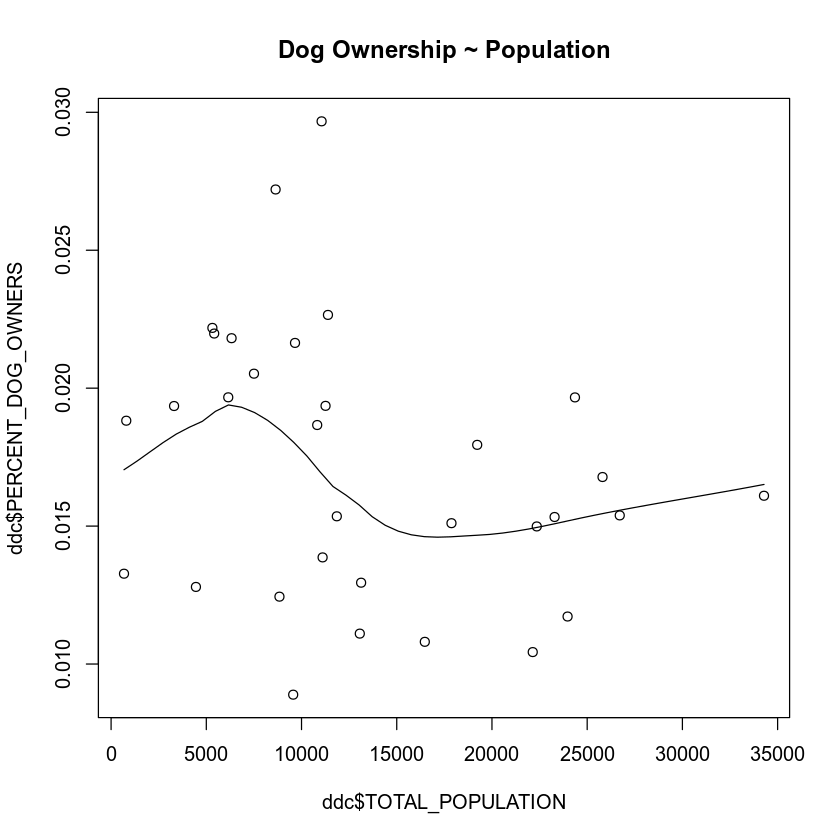

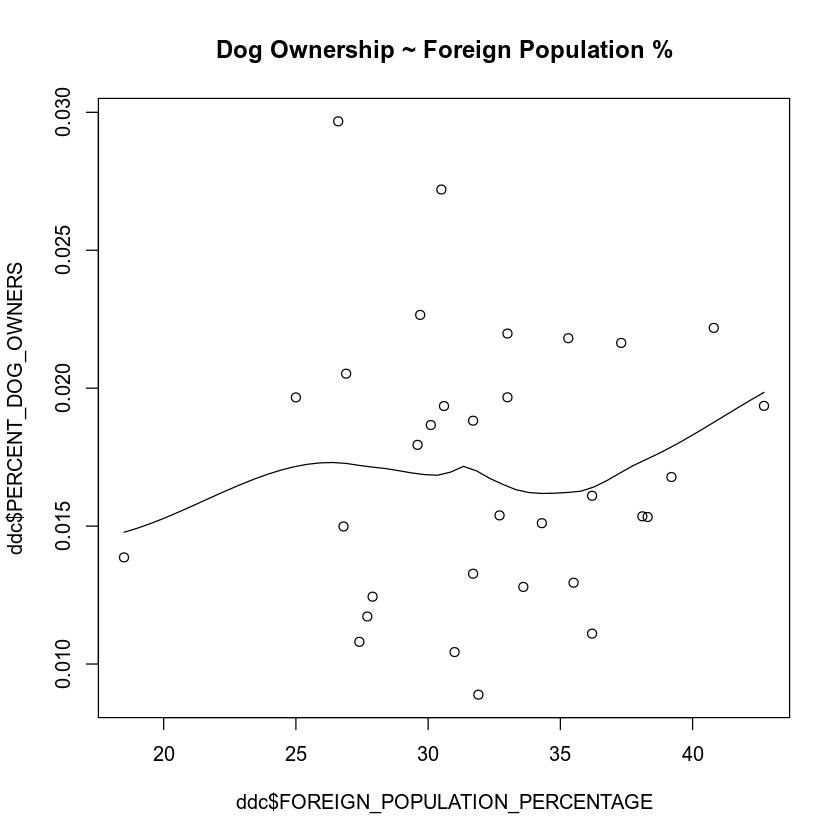

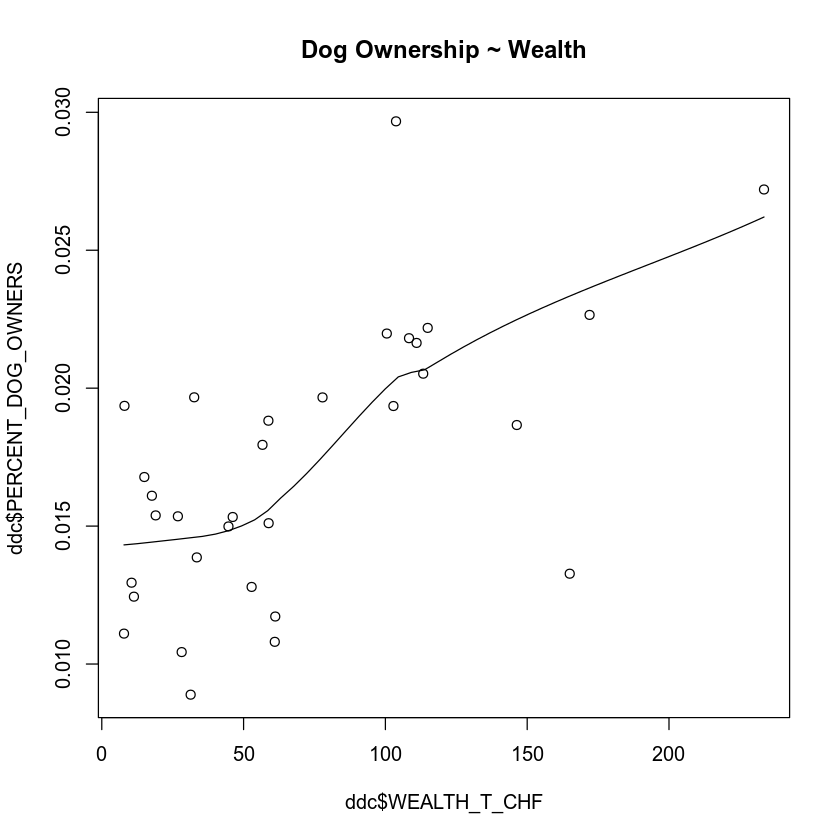

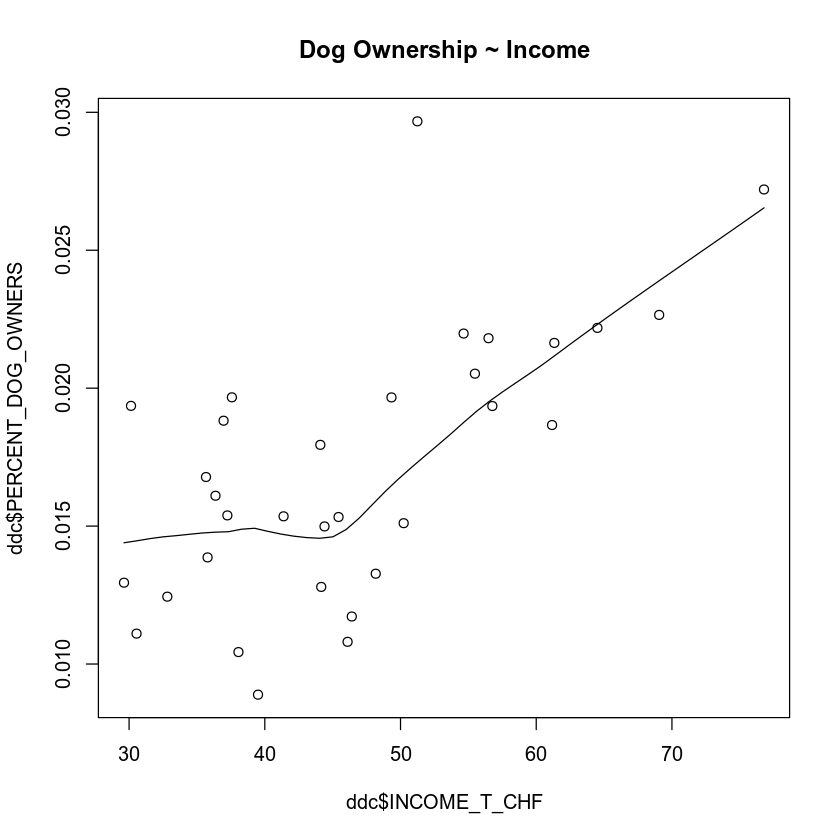

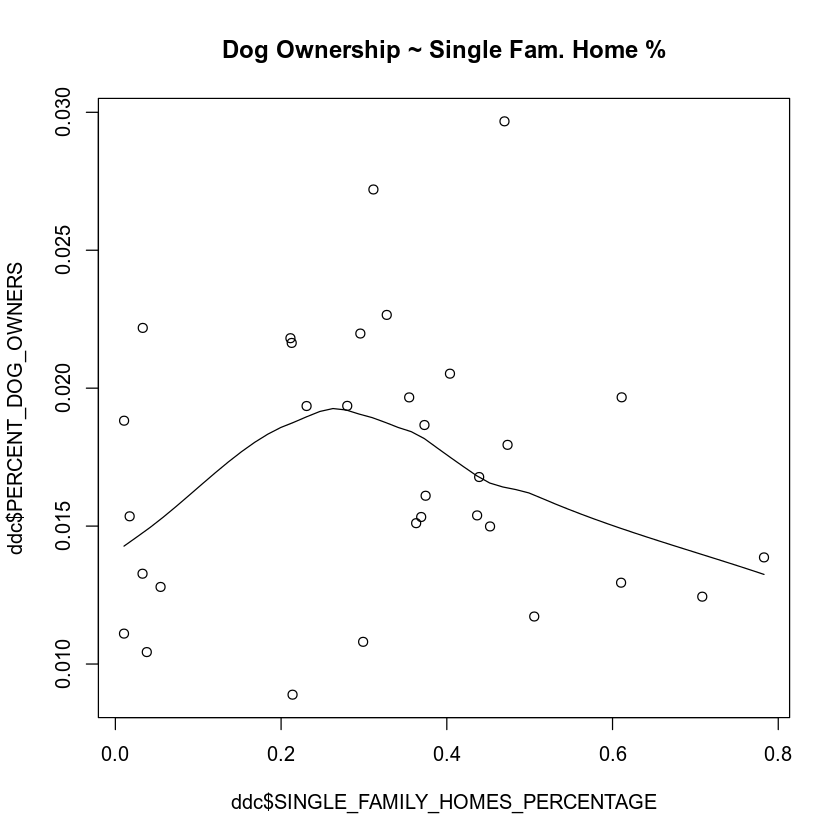

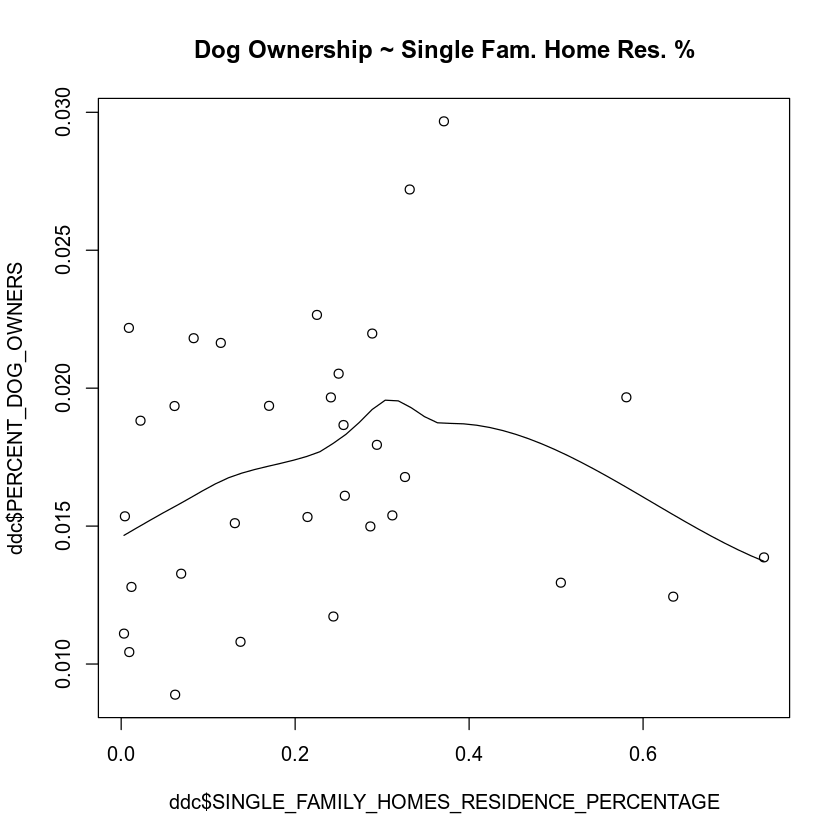

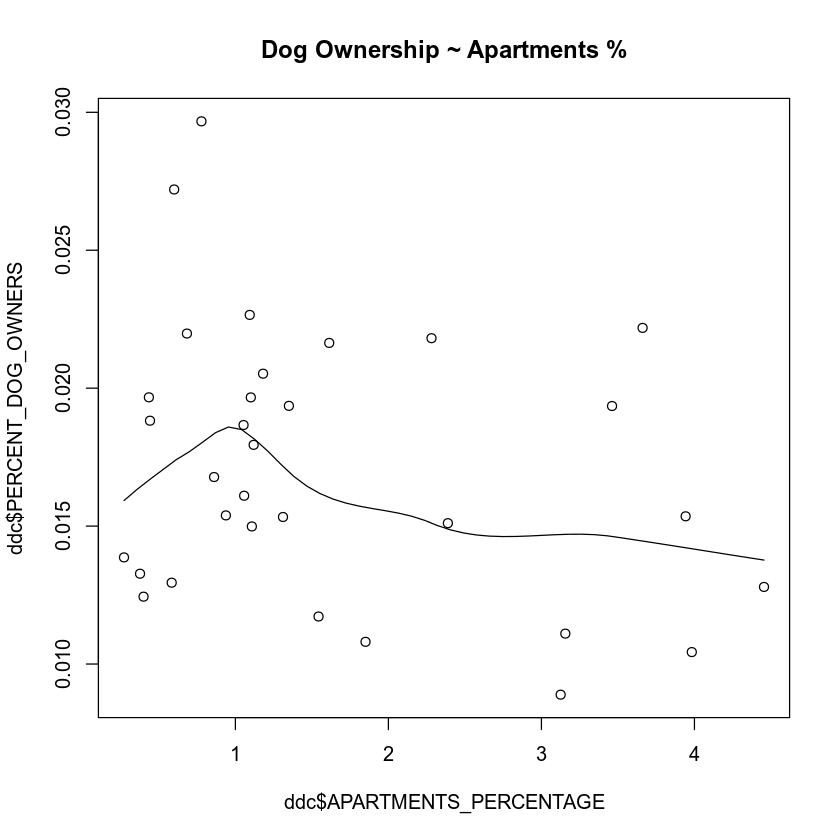

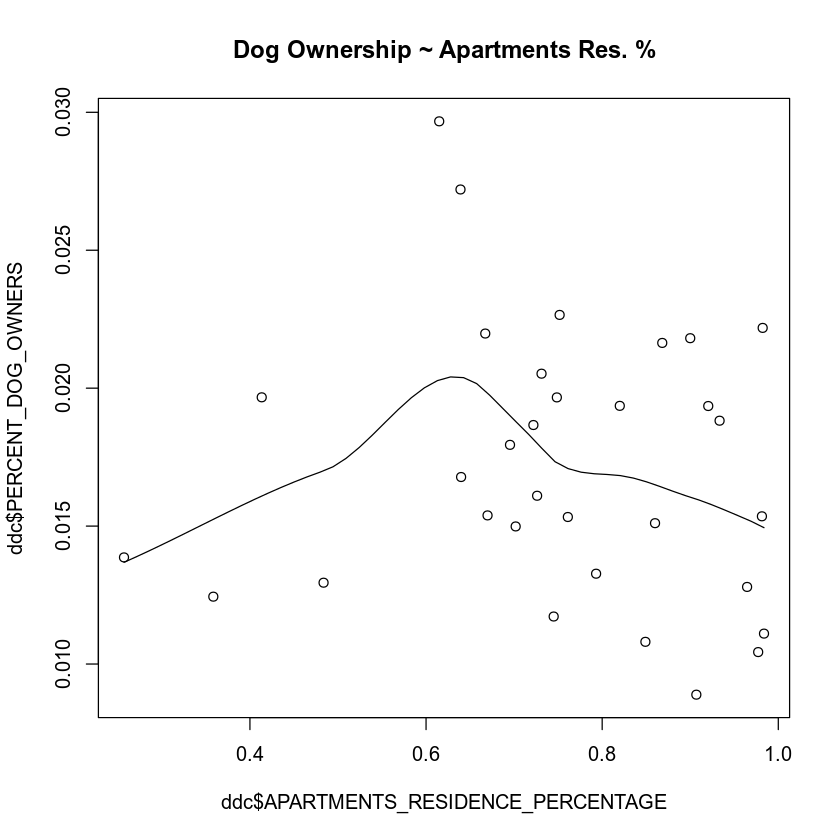

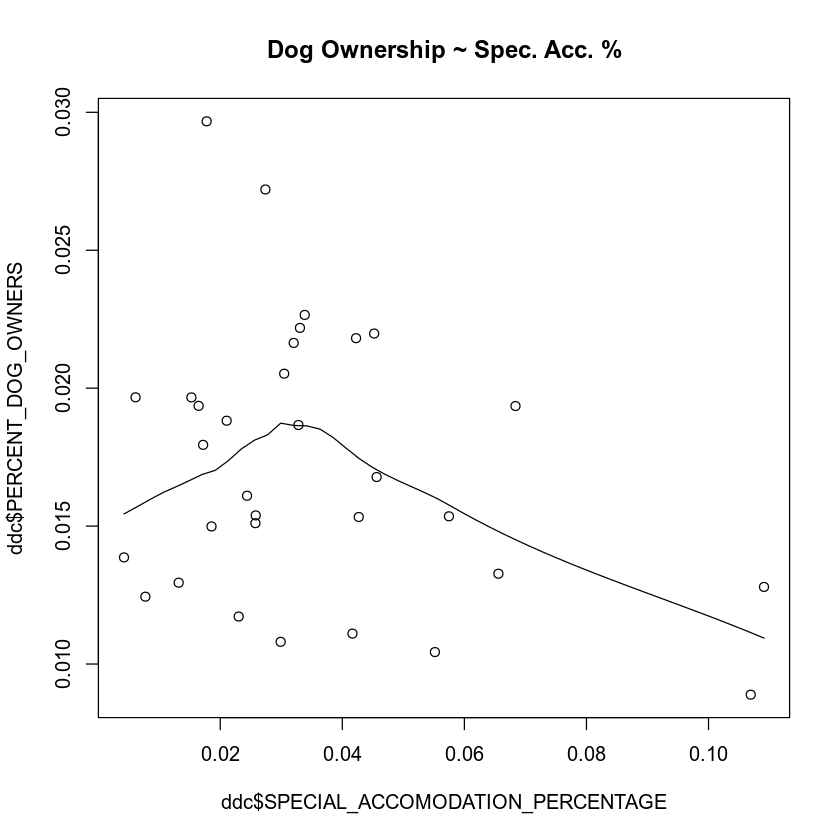

[1] 0.6250514

[1] 0.6491547

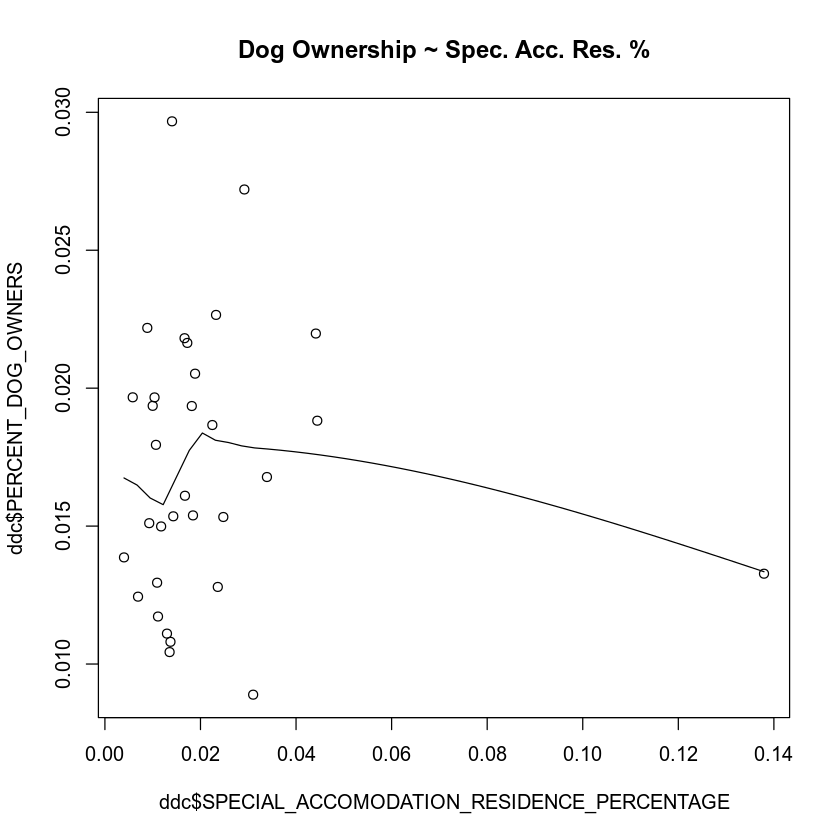

In [56]:
# Compute Scatter Plots for Preliminary Investigation of Independent Variables
scatter.smooth(x=ddc$TOTAL_POPULATION, y=ddc$PERCENT_DOG_OWNERS, main="Dog Ownership ~ Population")
scatter.smooth(x=ddc$FOREIGN_POPULATION_PERCENTAGE, y=ddc$PERCENT_DOG_OWNERS, main="Dog Ownership ~ Foreign Population %")

scatter.smooth(x=ddc$WEALTH_T_CHF, y=ddc$PERCENT_DOG_OWNERS, main="Dog Ownership ~ Wealth")
scatter.smooth(x=ddc$INCOME_T_CHF, y=ddc$PERCENT_DOG_OWNERS, main="Dog Ownership ~ Income")

scatter.smooth(x=ddc$SINGLE_FAMILY_HOMES_PERCENTAGE, y=ddc$PERCENT_DOG_OWNERS, main="Dog Ownership ~ Single Fam. Home %")
scatter.smooth(x=ddc$SINGLE_FAMILY_HOMES_RESIDENCE_PERCENTAGE, y=ddc$PERCENT_DOG_OWNERS, main="Dog Ownership ~ Single Fam. Home Res. %")

scatter.smooth(x=ddc$APARTMENTS_PERCENTAGE, y=ddc$PERCENT_DOG_OWNERS, main="Dog Ownership ~ Apartments %")
scatter.smooth(x=ddc$APARTMENTS_RESIDENCE_PERCENTAGE, y=ddc$PERCENT_DOG_OWNERS, main="Dog Ownership ~ Apartments Res. %")

scatter.smooth(x=ddc$SPECIAL_ACCOMODATION_PERCENTAGE, y=ddc$PERCENT_DOG_OWNERS, main="Dog Ownership ~ Spec. Acc. %")
scatter.smooth(x=ddc$SPECIAL_ACCOMODATION_RESIDENCE_PERCENTAGE, y=ddc$PERCENT_DOG_OWNERS, main="Dog Ownership ~ Spec. Acc. Res. %")

# Based upon the plots we decide to investigate the quality of wealth and income on Dog Ownership %
cor(ddc$PERCENT_DOG_OWNERS, ddc$WEALTH_T_CHF)
cor(ddc$PERCENT_DOG_OWNERS, ddc$INCOME_T_CHF)

# Two Independent Regressions
linearModWealth <- lm(PERCENT_DOG_OWNERS ~ WEALTH_T_CHF, data=ddc)
linearModIncome <- lm(PERCENT_DOG_OWNERS ~ INCOME_T_CHF, data=ddc)
linearModCombi <- lm(PERCENT_DOG_OWNERS ~ WEALTH_T_CHF + INCOME_T_CHF, data=ddc)

Only income seems to have a reliable effect - Rsq: 0.4214, independent variable is statistically significant. Each additional 1000 CHF of income predicts an additional 0.0269% increase in dog ownership.

In [57]:
summary(linearModIncome)


Call:
lm(formula = PERCENT_DOG_OWNERS ~ INCOME_T_CHF, data = ddc)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0063741 -0.0019223 -0.0000986  0.0018005  0.0112546 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.652e-03  2.754e-03   1.689    0.102    
INCOME_T_CHF 2.686e-04  5.747e-05   4.674 5.83e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.003783 on 30 degrees of freedom
Multiple R-squared:  0.4214,	Adjusted R-squared:  0.4021 
F-statistic: 21.85 on 1 and 30 DF,  p-value: 5.835e-05


## Investigation 2
Now we will start again from the beginning investigating the qualities of owners that may determine breed selection.

### Subset Data

In [ ]:
# Subset our Data
dog_owner_chars <- subset(dogs2020, select=c("BREED", "BREED_TYPE", "YOB_DOG", "SEX_DOG", "COLOR_DOG", 
                                             "OWNER_ID", "AGE", "SEX", "WEALTH_T_CHF", "INCOME_T_CHF", 
                                             "DISTRICT_NAME"))

# Remove Outlier Breeds (<20 Entries)
dog_owner_chars <- ddply(dog_owner_chars, "BREED", function(d) {if(nrow(d)>19) d else NULL})
# A helper data frame with Unique Breeds
unique_common_breeds <- unique(subset(dog_owner_chars, select=c("BREED")))

### Naive Bayes Model

In [ ]:
setDT(dog_owner_chars)

# Needs to Be Replaced with Whole Data Set No? Not Just first 100
dog_owner_chars <- subset(dog_owner_chars, select=c("BREED", "AGE", "SEX"))

# Naive Bayes Implementation
nb <- naiveBayes(BREED ~ ., data=dog_owner_chars, laplace = 0, na.action = na.pass)

# convert nb into a data frame
nb_df_age <- as.data.frame(nb$tables$AGE)

for (i in 1:length(unique_common_breeds$BREED)) {
  breed_name <- unique_common_breeds$BREED[i]
  breed <- which(nb_df_age$Y == breed_name)
  # create data frame for breed values
  d_age <- data.frame(x = nb_df_age[breed,]$AGE, y = nb_df_age[breed,]$Freq)
  # create plot
  plot <- ggplot(d_age, aes(x = x, y = y, group = 1)) + geom_point() + geom_line() + 
    labs(x = "Age group", y = "Frequency", title = paste(breed_name, "frequency per age group"))
  print(plot)
}

# similar approach for sex
nb_df_sex <- as.data.frame(nb$tables$SEX)

for (i in 1:length(unique_common_breeds$BREED)) {
  breed_name <- unique_common_breeds$BREED[i]
  breed <- which(nb_df_sex$Y == breed_name)
  # create data frame for sex values
  # geom_bar() in ggplot2 takes all of the values that one wants to plot in the bar plot and automatically calculates teh frquency. 
  # Here the frequency is already given. 
  # A workaround is to create a data frame that replicates the frequency value with respect the number given for frequency, such that the right amount of values is output
  rep_freq_f <- cbind("x" = rep(nb_df_sex[breed,]$Freq[1], nb_df_sex[breed,]$Freq[1]*100),
                      "y" = rep("f", nb_df_sex[breed,]$Freq[1]*100))
  rep_freq_m <- cbind("x" = rep(nb_df_sex[breed,]$Freq[2], nb_df_sex[breed,]$Freq[2]*100),
                      "y" = rep("m", nb_df_sex[breed,]$Freq[2]*100))
  freq <- as.data.frame(rbind(rep_freq_f, rep_freq_m))
  # create plot
  plot <- ggplot(freq, aes(x = y)) + geom_bar() + 
    labs(x = "Age group", y = "Frequency", title = paste(breed_name, "frequency per sex")) 
  print(plot)
}

# general breed plot 
ggplot(d_age, aes(x = x.dog_owner_chars.AGE, y = y.Freq)) + geom_point()

# Comparison



# Visualization

Here we build a visualisation over the districts of Zürich.



In [ ]:
library(dplyr)
library(leaflet)
library(rgdal)

load('dogs.RData')

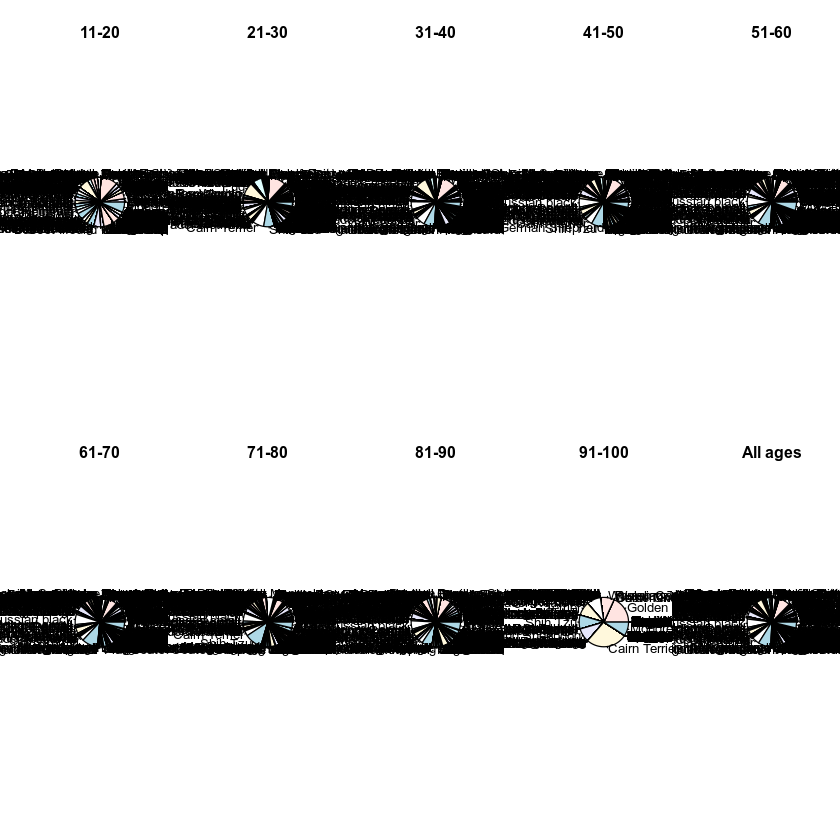

In [42]:
######################################
# Owner Age - Dog Breed Relationship #
######################################

# Generate breeds table for totals
breeds <- table(breed=dogs2020$BREED, age=dogs2020$AGE)
breeds <- cbind(breeds, total = rowSums(breeds)) %>%
as.data.frame()

# Use pie charts to visualise
par(mfrow = c(2,5))
pie(breeds$`11-20`, dogs2020$BREED, main="11-20")
pie(breeds$`21-30`, dogs2020$BREED, main="21-30")
pie(breeds$`31-40`, dogs2020$BREED, main="31-40")
pie(breeds$`41-50`, dogs2020$BREED, main="41-50")
pie(breeds$`51-60`, dogs2020$BREED, main="51-60")
pie(breeds$`61-70`, dogs2020$BREED, main="61-70")
pie(breeds$`71-80`, dogs2020$BREED, main="71-80")
pie(breeds$`81-90`, dogs2020$BREED, main="81-90")
pie(breeds$`91-100`, dogs2020$BREED, main="91-100")
pie(breeds$total, dogs2020$BREED, main="All ages")

# Delete generated table
rm(breeds)


In [ ]:
zh_rg <- readOGR("./data_sources/stzh.adm_stadtkreise_v.json")

# group sub-districts together
list_districts <- list(
  District_1 <- c(
    "Rathaus",
    "Hochschulen",
    "Lindenhof",
    "City"
  ),
  District_2	<- c(
    "Wollishofen",
    "Leimbach",
    "Enge"
  ),
  District_3 <- c(
    "Alt-Wiedikon",
    "Friesenberg",
    "Sihlfeld"
  ),
  District_4 <- c(
    "Werd",
    "Langstrasse",
    "Hard"
  ),
  District_5 <- c(
    "Gewerbeschule",
    "Escher Wyss"
  ),
  District_6	<- c(
    "Unterstrass",
    "Oberstrass",
    "Unterstrass"
  ),
  District_7 <- c(		
    "Fluntern",
    "Hottingen",
    "Hirslanden",
    "Witikon"
  ),
  District_8 <- c(
    "Seefeld",
    "Mühlebach",
    "Weinegg"
  ),
  District_9 <- c(	
    "Albisrieden",
    "Altstetten"
  ),
  District_10 <- c(	
    "Höngg",
    "Wipkingen"
  ),
  District_11 <- c(	
    "Affoltern",
    "Oerlikon",
    "Seebach"
  ),
  District_12 <- c(
    "Saatlen",
    "Schwamendingen-Mitte",
    "Hirzenbach"
  )
)
avg_wealth <- unlist(lapply(seq_len(length(list_districts)), function (z) {
  mean(unlist(lapply(list_districts[[z]], function (y) {
    mean(unlist(lapply(y, function (x) {
      dogs2020[which(x == dogs2020$DISTRICT_NAME),]$WEALTH_T_CHF
    })))
  })))
}))


In [43]:
bins <- c(0, 25, 30, 50, 60, 75, 100, 120, 150, 175)
pal <- colorBin("Greens", domain = avg_wealth, bins = bins)

leaflet(zh_rg) %>%
  addPolygons(fillColor = ~pal(unlist(avg_wealth)), weight = 2, fillOpacity = 0.9, 
              opacity = 1) %>%
  addTiles() %>% 
  addLegend(colors = pal(unlist(avg_wealth)), labels = zh_rg$kname, title = "Zurich Districts", opacity = 1)


ERROR: Error in colorBin("Greens", domain = avg_wealth, bins = bins): object 'avg_wealth' not found
